In [94]:
import numpy as np 
import cvxopt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools

In [95]:
MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5
np.random.seed(101)

In [96]:
class svm(object):
    def __init__(self, c):
        self.c = c


    def gramMatrix(self, x):
        # calculates the gram matrix for size (n_samples, n_samples)
        n_samples, n_features = x.shape
        mat = np.zeros((n_samples, n_samples))
        for i, x_i in enumerate(x):
            for j, x_j in enumerate(x):
                mat[i, j] = np.inner(x_i, x_j)
        print('\nGram matrix is : \n', mat, '\n')
        return mat


    def lagrangeMultipliers(self, x, y):
        n_samples, n_features = x.shape
        gmat = self.gramMatrix(x)
        
        # solve min (1/2 * x^T * P * x + q^T * x) s.t. (G * x <= h) and (A * x = b)
        P = cvxopt.matrix(np.outer(y ,y) * gmat)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        
        # Hard margin :: -a_i <= 0
        G_hard = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_hard = cvxopt.matrix(np.zeros(n_samples))
        
        # slack :: a_i <= c
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self.c)
        
        # stack vertically the g and h matrices respectively
        G = cvxopt.matrix(np.vstack((G_hard, G_slack)))
        h = cvxopt.matrix(np.vstack((h_hard, h_slack)))
        
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        solutions = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        print('\nLagrange multipliers are ', np.ravel(solutions['x']), '\n')
        
        #return the lagrange multipliers
        return np.ravel(solutions['x'])


    def createPredictor(self, x, y, lag_mult):
        sv_indices = lag_mult > MIN_SUPPORT_VECTOR_MULTIPLIER
        print('Support vector indices are :\n', sv_indices, '\n')
        sv_multipliers = lag_mult[sv_indices]
        print('\nsupport vector multipliers (weights) are :\n', sv_multipliers, '\n')
        
        sv = x[sv_indices]
        sv_labels = y[sv_indices]
        
        print('\nSupport vector coordinates are : \n')
        for a,b in zip(sv, sv_labels):
            print(a, b)
            
        # bias = y_k - sum(alpha_i * y_i * x_i * x_k)
        bias = np.mean([y_k - svmPredictor(bias=0.0, weights=sv_multipliers, support_vectors=sv, 
                                           support_vector_labels=sv_labels).predict(x_k)
                        for (y_k,x_k) in zip(sv_labels, sv)])
        
        
        return svmPredictor(bias=bias, weights=sv_multipliers, support_vectors=sv, support_vector_labels=sv_labels)

    
    def train(self, x, y):
        # x : training features
        # y : labels
        # returns svm predictor representing trained svm
        lag_mult = self.lagrangeMultipliers(x, y)
        return self.createPredictor(x, y, lag_mult)

# Pass the trained support vectors and lagrange multipliers and weights to svmPredictor

In [97]:
class svmPredictor(object):
    def __init__ (self, bias, weights, support_vectors, support_vector_labels):
        self.bias = bias
        self.weights = weights
        self.support_vectors = support_vectors
        self.support_vector_labels = support_vector_labels


    def predict(self, x):
        # Computing svm predictions for provided x
        y_pred = self.bias
        
        for alpha_i, x_i, y_i in zip(self.weights, self.support_vectors, self.support_vector_labels):
            y_pred += alpha_i * y_i * np.inner(x_i, x)
            
        return np.sign(y_pred).item()


Gram matrix is : 
 [[ 7.72158675  2.77420639  1.5619044  -1.91499039 -4.99798351  1.06144822
   0.03409751 -1.92623078  1.75937378  7.4832964 ]
 [ 2.77420639  1.07824891  0.43031455 -0.46472704 -1.45954255  0.18339286
  -0.21100971 -0.36616881  1.17018432  2.71050805]
 [ 1.5619044   0.43031455  0.5259186  -0.74569382 -1.55039989  0.53239846
   0.36518444 -0.91261428 -0.50762331  1.47853535]
 [-1.91499039 -0.46472704 -0.74569382  1.08642857  2.16005036 -0.80538847
  -0.61987832  1.37018815  1.0372501  -1.79587817]
 [-4.99798351 -1.45954255 -1.55039989  2.16005036  4.62078372 -1.50316689
  -0.94247683  2.5902881   1.0794669  -4.75340041]
 [ 1.06144822  0.18339286  0.53239846 -0.80538847 -1.50316689  0.62656534
   0.54676067 -1.05603723 -1.06459451  0.97548356]
 [ 0.03409751 -0.21100971  0.36518444 -0.61987832 -0.94247683  0.54676067
   0.61149272 -0.90086318 -1.46562165 -0.02696199]
 [-1.92623078 -0.36616881 -0.91261428  1.37018815  2.5902881  -1.05603723
  -0.90086318  1.78306464  1.71

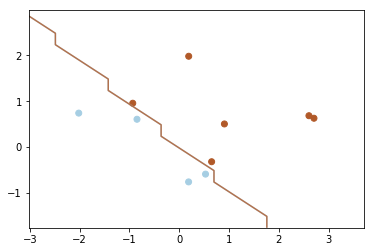

In [98]:
def samplePlot(n_samples = 10, n_features=2, grid_size=20):
    samples = np.matrix(np.random.normal(size=(n_samples * n_features)).reshape(n_samples, n_features))
    labels = 2 * (samples.sum(axis=1) > 0) - 1.0
    
    svm_clf = svm(0.01)
    predictor = svm_clf.train(samples, labels)
    
    plot(predictor, samples, labels, grid_size)

    
def plot(predictor, x, y, grid_size):
    x_min = x[:, 0].min() - 1
    x_max = x[:, 0].max() + 1
    
    y_min = x[:, 1].min() - 1
    y_max = x[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size), indexing='ij')
    
    flatten = lambda m: np.array(m).reshape(-1)
    
    result = []
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))
        
    z = np.array(result).reshape(xx.shape)

    plt.contour(xx, yy, z, cmap=cm.Paired, levels=[-0.001, 0.001],
               extend='both', alpha=0.8)

    plt.scatter(flatten(x[:, 0]), flatten(x[:, 1]), c=flatten(y), cmap=cm.Paired)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


if __name__ == "__main__":
    samplePlot()
    
    